## Data Preparation

In [266]:
import itertools
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import json
import os
from bisect import bisect
from abc import *
from enum import Enum
import gurobipy as gp
from gurobipy import GRB
import random
from scipy import stats


### Utils

In [267]:
def powerset_by_length(items, min_len=1, max_len_exclusive=None):
    "Generate the subsets of elements in the iterable, in order by length."
    if max_len_exclusive is None:
        max_len_exclusive = len(items)+1
    for k in range(min_len, max_len_exclusive):
        for subset in itertools.combinations(items, k):
            yield subset

def values_key(tup_key):
    return tup_key[0] if len(tup_key) == 1 else tup_key

In [268]:
order = [(1, 1), (1, 2), ((1, 1), (1, 2)), (1, 3), ((1, 1), (1, 3)), ((1, 2), (1, 3)), ((1, 1), (1, 2), (1, 3)), (2, 1), ((1, 1), (2, 1)), ((1, 2), (2, 1)), ((1, 1), (1, 2), (2, 1)), ((1, 3), (2, 1)), ((1, 1), (1, 3), (2, 1)), ((1, 2), (1, 3), (2, 1)), ((1, 1), (1, 2), (1, 3), (2, 1)), (2, 2), ((1, 1), (2, 2)), ((1, 2), (2, 2)), ((1, 1), (1, 2), (2, 2)), ((1, 3), (2, 2)), ((1, 1), (1, 3), (2, 2)), ((1, 2), (1, 3), (2, 2)), ((1, 1), (1, 2), (1, 3), (2, 2)), ((2, 1), (2, 2)), ((1, 1), (2, 1), (2, 2)), ((1, 2), (2, 1), (2, 2)), ((1, 1), (1, 2), (2, 1), (2, 2)), ((1, 3), (2, 1), (2, 2)), ((1, 1), (1, 3), (2, 1), (2, 2)), ((1, 2), (1, 3), (2, 1), (2, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2)), (2, 3), ((1, 1), (2, 3)), ((1, 2), (2, 3)), ((1, 1), (1, 2), (2, 3)), ((1, 3), (2, 3)), ((1, 1), (1, 3), (2, 3)), ((1, 2), (1, 3), (2, 3)), ((1, 1), (1, 2), (1, 3), (2, 3)), ((2, 1), (2, 3)), ((1, 1), (2, 1), (2, 3)), ((1, 2), (2, 1), (2, 3)), ((1, 1), (1, 2), (2, 1), (2, 3)), ((1, 3), (2, 1), (2, 3)), ((1, 1), (1, 3), (2, 1), (2, 3)), ((1, 2), (1, 3), (2, 1), (2, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3)), ((2, 2), (2, 3)), ((1, 1), (2, 2), (2, 3)), ((1, 2), (2, 2), (2, 3)), ((1, 1), (1, 2), (2, 2), (2, 3)), ((1, 3), (2, 2), (2, 3)), ((1, 1), (1, 3), (2, 2), (2, 3)), ((1, 2), (1, 3), (2, 2), (2, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3)), ((2, 1), (2, 2), (2, 3)), ((1, 1), (2, 1), (2, 2), (2, 3)), ((1, 2), (2, 1), (2, 2), (2, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3)), ((1, 3), (2, 1), (2, 2), (2, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)), (3, 1), ((1, 1), (3, 1)), ((1, 2), (3, 1)), ((1, 1), (1, 2), (3, 1)), ((1, 3), (3, 1)), ((1, 1), (1, 3), (3, 1)), ((1, 2), (1, 3), (3, 1)), ((1, 1), (1, 2), (1, 3), (3, 1)), ((2, 1), (3, 1)), ((1, 1), (2, 1), (3, 1)), ((1, 2), (2, 1), (3, 1)), ((1, 1), (1, 2), (2, 1), (3, 1)), ((1, 3), (2, 1), (3, 1)), ((1, 1), (1, 3), (2, 1), (3, 1)), ((1, 2), (1, 3), (2, 1), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 1)), ((2, 2), (3, 1)), ((1, 1), (2, 2), (3, 1)), ((1, 2), (2, 2), (3, 1)), ((1, 1), (1, 2), (2, 2), (3, 1)), ((1, 3), (2, 2), (3, 1)), ((1, 1), (1, 3), (2, 2), (3, 1)), ((1, 2), (1, 3), (2, 2), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 1)), ((2, 1), (2, 2), (3, 1)), ((1, 1), (2, 1), (2, 2), (3, 1)), ((1, 2), (2, 1), (2, 2), (3, 1)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1)), ((1, 3), (2, 1), (2, 2), (3, 1)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 1)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 1)), ((2, 3), (3, 1)), ((1, 1), (2, 3), (3, 1)), ((1, 2), (2, 3), (3, 1)), ((1, 1), (1, 2), (2, 3), (3, 1)), ((1, 3), (2, 3), (3, 1)), ((1, 1), (1, 3), (2, 3), (3, 1)), ((1, 2), (1, 3), (2, 3), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 1)), ((2, 1), (2, 3), (3, 1)), ((1, 1), (2, 1), (2, 3), (3, 1)), ((1, 2), (2, 1), (2, 3), (3, 1)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 1)), ((1, 3), (2, 1), (2, 3), (3, 1)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 1)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1)), ((2, 2), (2, 3), (3, 1)), ((1, 1), (2, 2), (2, 3), (3, 1)), ((1, 2), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 1)), ((1, 3), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 1)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 1)), ((2, 1), (2, 2), (2, 3), (3, 1)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1)), (3, 2), ((1, 1), (3, 2)), ((1, 2), (3, 2)), ((1, 1), (1, 2), (3, 2)), ((1, 3), (3, 2)), ((1, 1), (1, 3), (3, 2)), ((1, 2), (1, 3), (3, 2)), ((1, 1), (1, 2), (1, 3), (3, 2)), ((2, 1), (3, 2)), ((1, 1), (2, 1), (3, 2)), ((1, 2), (2, 1), (3, 2)), ((1, 1), (1, 2), (2, 1), (3, 2)), ((1, 3), (2, 1), (3, 2)), ((1, 1), (1, 3), (2, 1), (3, 2)), ((1, 2), (1, 3), (2, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 2)), ((2, 2), (3, 2)), ((1, 1), (2, 2), (3, 2)), ((1, 2), (2, 2), (3, 2)), ((1, 1), (1, 2), (2, 2), (3, 2)), ((1, 3), (2, 2), (3, 2)), ((1, 1), (1, 3), (2, 2), (3, 2)), ((1, 2), (1, 3), (2, 2), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 2)), ((2, 1), (2, 2), (3, 2)), ((1, 1), (2, 1), (2, 2), (3, 2)), ((1, 2), (2, 1), (2, 2), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 2)), ((1, 3), (2, 1), (2, 2), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 2)), ((2, 3), (3, 2)), ((1, 1), (2, 3), (3, 2)), ((1, 2), (2, 3), (3, 2)), ((1, 1), (1, 2), (2, 3), (3, 2)), ((1, 3), (2, 3), (3, 2)), ((1, 1), (1, 3), (2, 3), (3, 2)), ((1, 2), (1, 3), (2, 3), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 2)), ((2, 1), (2, 3), (3, 2)), ((1, 1), (2, 1), (2, 3), (3, 2)), ((1, 2), (2, 1), (2, 3), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 2)), ((1, 3), (2, 1), (2, 3), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 2)), ((2, 2), (2, 3), (3, 2)), ((1, 1), (2, 2), (2, 3), (3, 2)), ((1, 2), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 2)), ((1, 3), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 2)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 2)), ((2, 1), (2, 2), (2, 3), (3, 2)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2)), ((3, 1), (3, 2)), ((1, 1), (3, 1), (3, 2)), ((1, 2), (3, 1), (3, 2)), ((1, 1), (1, 2), (3, 1), (3, 2)), ((1, 3), (3, 1), (3, 2)), ((1, 1), (1, 3), (3, 1), (3, 2)), ((1, 2), (1, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (3, 1), (3, 2)), ((2, 1), (3, 1), (3, 2)), ((1, 1), (2, 1), (3, 1), (3, 2)), ((1, 2), (2, 1), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 1), (3, 1), (3, 2)), ((1, 3), (2, 1), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 1), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 1), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 1), (3, 2)), ((2, 2), (3, 1), (3, 2)), ((1, 1), (2, 2), (3, 1), (3, 2)), ((1, 2), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 2), (3, 1), (3, 2)), ((1, 3), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 2), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 1), (3, 2)), ((2, 1), (2, 2), (3, 1), (3, 2)), ((1, 1), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 2), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 3), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2)), ((2, 3), (3, 1), (3, 2)), ((1, 1), (2, 3), (3, 1), (3, 2)), ((1, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 3), (3, 1), (3, 2)), ((1, 3), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 3), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 1), (3, 2)), ((2, 1), (2, 3), (3, 1), (3, 2)), ((1, 1), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 2), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 3), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)), ((2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 2), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 3), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2)), ((2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2)), (3, 3), ((1, 1), (3, 3)), ((1, 2), (3, 3)), ((1, 1), (1, 2), (3, 3)), ((1, 3), (3, 3)), ((1, 1), (1, 3), (3, 3)), ((1, 2), (1, 3), (3, 3)), ((1, 1), (1, 2), (1, 3), (3, 3)), ((2, 1), (3, 3)), ((1, 1), (2, 1), (3, 3)), ((1, 2), (2, 1), (3, 3)), ((1, 1), (1, 2), (2, 1), (3, 3)), ((1, 3), (2, 1), (3, 3)), ((1, 1), (1, 3), (2, 1), (3, 3)), ((1, 2), (1, 3), (2, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 3)), ((2, 2), (3, 3)), ((1, 1), (2, 2), (3, 3)), ((1, 2), (2, 2), (3, 3)), ((1, 1), (1, 2), (2, 2), (3, 3)), ((1, 3), (2, 2), (3, 3)), ((1, 1), (1, 3), (2, 2), (3, 3)), ((1, 2), (1, 3), (2, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 3)), ((2, 1), (2, 2), (3, 3)), ((1, 1), (2, 1), (2, 2), (3, 3)), ((1, 2), (2, 1), (2, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 3)), ((1, 3), (2, 1), (2, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 3)), ((2, 3), (3, 3)), ((1, 1), (2, 3), (3, 3)), ((1, 2), (2, 3), (3, 3)), ((1, 1), (1, 2), (2, 3), (3, 3)), ((1, 3), (2, 3), (3, 3)), ((1, 1), (1, 3), (2, 3), (3, 3)), ((1, 2), (1, 3), (2, 3), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 3)), ((2, 1), (2, 3), (3, 3)), ((1, 1), (2, 1), (2, 3), (3, 3)), ((1, 2), (2, 1), (2, 3), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 3)), ((1, 3), (2, 1), (2, 3), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 3)), ((2, 2), (2, 3), (3, 3)), ((1, 1), (2, 2), (2, 3), (3, 3)), ((1, 2), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 3)), ((1, 3), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 3)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), ((2, 1), (2, 2), (2, 3), (3, 3)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 3)), ((3, 1), (3, 3)), ((1, 1), (3, 1), (3, 3)), ((1, 2), (3, 1), (3, 3)), ((1, 1), (1, 2), (3, 1), (3, 3)), ((1, 3), (3, 1), (3, 3)), ((1, 1), (1, 3), (3, 1), (3, 3)), ((1, 2), (1, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (3, 1), (3, 3)), ((2, 1), (3, 1), (3, 3)), ((1, 1), (2, 1), (3, 1), (3, 3)), ((1, 2), (2, 1), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 1), (3, 1), (3, 3)), ((1, 3), (2, 1), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 1), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 1), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 1), (3, 3)), ((2, 2), (3, 1), (3, 3)), ((1, 1), (2, 2), (3, 1), (3, 3)), ((1, 2), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 2), (3, 1), (3, 3)), ((1, 3), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 2), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 1), (3, 3)), ((2, 1), (2, 2), (3, 1), (3, 3)), ((1, 1), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 2), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 3), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 3)), ((2, 3), (3, 1), (3, 3)), ((1, 1), (2, 3), (3, 1), (3, 3)), ((1, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 3), (3, 1), (3, 3)), ((1, 3), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 3), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 1), (3, 3)), ((2, 1), (2, 3), (3, 1), (3, 3)), ((1, 1), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 2), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 3), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 3)), ((2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 2), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 3), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 3)), ((2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 3)), ((3, 2), (3, 3)), ((1, 1), (3, 2), (3, 3)), ((1, 2), (3, 2), (3, 3)), ((1, 1), (1, 2), (3, 2), (3, 3)), ((1, 3), (3, 2), (3, 3)), ((1, 1), (1, 3), (3, 2), (3, 3)), ((1, 2), (1, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (3, 2), (3, 3)), ((2, 1), (3, 2), (3, 3)), ((1, 1), (2, 1), (3, 2), (3, 3)), ((1, 2), (2, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (3, 2), (3, 3)), ((1, 3), (2, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 2), (3, 3)), ((2, 2), (3, 2), (3, 3)), ((1, 1), (2, 2), (3, 2), (3, 3)), ((1, 2), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 2), (3, 2), (3, 3)), ((1, 3), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 2), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 2), (3, 3)), ((2, 1), (2, 2), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 2), (3, 3)), ((2, 3), (3, 2), (3, 3)), ((1, 1), (2, 3), (3, 2), (3, 3)), ((1, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 3), (3, 2), (3, 3)), ((1, 3), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 3), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 2), (3, 3)), ((2, 1), (2, 3), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 2), (3, 3)), ((2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 2), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 3), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 2), (3, 3)), ((2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3)), ((3, 1), (3, 2), (3, 3)), ((1, 1), (3, 1), (3, 2), (3, 3)), ((1, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (3, 1), (3, 2), (3, 3)), ((1, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (3, 1), (3, 2), (3, 3)), ((2, 1), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (3, 1), (3, 2), (3, 3)), ((2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (3, 1), (3, 2), (3, 3)), ((2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)), ((2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 3), (3, 1), (3, 2), (3, 3)), ((2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)), ((2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)), ((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3))]

# lands = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]
# land_ord = []

# for lst in z:
#     name = []
#     for i, (bundle, piece) in enumerate(zip(lst, lands)):
#         if (bundle==1):
#             name.append(piece)
#     if len(name)==1:
#         land_ord.append(name[0])
#     else:
#         land_ord.append(tuple(name))


### Automatic Valuation Generation

In [269]:
class AuctionItem(ABC):
    @property
    @abstractmethod
    def identifier(self):
        pass

    @property
    @abstractmethod
    def cost(self) -> float:
        pass

    def __repr__(self):
        return f'{self.identifier}:{self.cost}'

    def __str__(self):
        return f'{self.identifier}'

@AuctionItem.register
class Land:
    def __init__(self, identifier: tuple[int, int], cost: int):
        self.identifier: tuple[int, int] = identifier
        self.cost: int = cost
        

class ValuationMode(Enum):
    sets = 'sets'
    neighbors = 'neighbors'

In [270]:
class ValuationFunction(ABC):

    @abstractmethod
    def generate_valuations(self, auction, mult):
        vals = {}
        for item in auction.items:
            val = np.random.randint(0, auction.value_max)
            while (val < auction.costs[item]):
                val = np.random.randint(0, auction.value_max)
            vals[item] = val
        return vals
    

@ValuationFunction.register
class AdditiveValuation():

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                values[subset] = sum([values[s] for s in subset])
        else:
            for item in auction.itemgroups_to_value:
                values[item] = [values[item]] * (auction.max_num_neighbors+1)
        return values


    
@ValuationFunction.register
class SuperadditiveValuation():
        
    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                values[subset] = sum([values[s] for s in subset])
            for subset in auction.itemgroups_to_value:
                if (subset not in auction.items):
                    values[subset] = values[subset] * mult
        else:
            for item in auction.itemgroups_to_value:
                values[item] = [values[item]] * (auction.max_num_neighbors+1)
        return values


@ValuationFunction.register
class SubmodularNonmonotoneValuation(ValuationFunction):

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                max_val = min([
                    values[values_key(subsubset)] + values[values_key(subsubset2)] \
                        - values.get(values_key(tuple(sorted(set(subsubset) & set(subsubset2)))), 0) # intersection of two sub-subsets
                    for subsubset in powerset_by_length(subset, len(subset)//2, len(subset))
                    for subsubset2 in powerset_by_length(subset, 1, len(subset))
                    if (set(subsubset) | set(subsubset2)) == set(subset)
                ])
                values[subset] = np.random.randint(max_val*0.9, max_val)
        return values


@ValuationFunction.register
class SubmodularMonotoneValuation(ValuationFunction):

    def generate_valuations(self, auction, mult):
        values = ValuationFunction.generate_valuations(self, auction, mult)
        if auction.valuation_mode == ValuationMode.sets:
            for subset in auction.itemgroups_to_value:
                if subset in values:
                    continue
                max_val = min([
                    values[values_key(subsubset)] + values[values_key(subsubset2)] \
                        - values.get(tuple(sorted(set(subsubset) & set(subsubset2))), 0) 
                    for subsubset in powerset_by_length(subset, len(subset)//2, len(subset))
                    for subsubset2 in powerset_by_length(subset, 1, len(subset))
                    if (set(subsubset) | set(subsubset2)) == set(subset)
                ])
                min_val = max([values[values_key(subsubset)] for subsubset in powerset_by_length(subset, 1, len(subset))])
                values[subset] = max(min_val, max_val - np.random.randint(0, max(1, min(max_val*0.25, (max_val-min_val)*0.35)))) # this part I'm not sure of, the subtraction of this int
        return values

## Model Solving

In [271]:
class Auction:
    
    max_num_neighbors = 2
    # TODO vary
    costs_max = 50
    value_max = 100
    benefits_diff = 10
    max_diff = 5

    def __init__(self, valuation_function: ValuationFunction, items: list[AuctionItem], valuation_mode: ValuationMode, budg: int, mult: float):
        self.valuation_function: ValuationFunction = valuation_function
        self.item_objs: list[AuctionItem] = items
        self.items: list[str] = [item.identifier for item in items]
        self.costs = {item.identifier: item.cost for item in self.item_objs}
        self.valuation_mode: ValuationMode = valuation_mode
        self.itemgroups_to_value = self.items + list(powerset_by_length(self.items, 2)) \
            if valuation_mode == ValuationMode.sets \
            else self.items
        self.values: dict[Set[AuctionItem], float] = self.valuation_function.generate_valuations(self, mult)
        self.corridor_value: dict[Set[AuctionItem], float] = {}
        self.budget = budg
        self.multi = mult
        
        ## ADJACENCY COMPUTATION STARTS HERE
        # for itemgroup in self.itemgroups_to_value:
        #     if itemgroup not in self.items:
        #         marginal_value = 0
        #         max_single_val = 0
        #         for single in itemgroup:
        #             row, col = single[0], single[1]
        #             if (self.values[single] > max_single_val):
        #                 max_single_val = self.values[single]
        #             for adjacent in [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]:
        #                 if adjacent in itemgroup:
        #                     marginal_value += self.values[single]
        #                     # marginal_value -= random.uniform(0,2)
        #                     break
        #         if (self.values[itemgroup] - marginal_value*self.multi) < max_single_val:
        #             self.values[itemgroup] = max_single_val + random.uniform(0,1)
        #         else:
        #             self.values[itemgroup] -= marginal_value*self.multi
            ## ADJACENCY COMPUTATION ENDS HERE

                
        ## CORRIDOR COMPUTATION STARTS HERE
        for item_set in self.itemgroups_to_value:
            corridor, check = 0, 0
            list_i, list_j = [], []
            for item_single in item_set:
                if (isinstance(item_single,int) == False):
                    list_i.append(item_single[0])
                    list_j.append(item_single[1])
            
            for i in list_i:
                if (list_i.count(i) == 3):
                    check += 1

            if (check == len(list_i)) and (check > 0):
                corridor = (check / 3)

            value_sum, count = 0, 0
            if (corridor == 1):
                self.values[item_set] = self.values[item_set] * mult
                self.corridor_value[item_set] = self.values[item_set]
            elif (corridor == 2):
                for subset in self.corridor_value:
                    flag = 1
                    for item_single in subset:
                        if item_single not in item_set:
                            flag = 0
                    if (flag != 0):
                        value_sum += self.values[subset]
                        count += 1
                self.values[item_set] = value_sum
                self.corridor_value[item_set] = self.values[item_set]
            
            min = 1e+05

            if (corridor > 2):
                for this_item in self.corridor_value:
                   if (len(this_item) > 3):
                        for that_item in self.corridor_value:
                            if (len(that_item) > 3):
                                if (set(this_item) | set(that_item) == set(item_set)):
                                    intersect = self.values.get(values_key(tuple(sorted(set(this_item) & set(that_item)))), 0) 
                                    if (self.values[this_item] + self.values[that_item] - intersect) < min:
                                        min = self.values[this_item] + self.values[that_item] - intersect
                self.values[item_set] = min 
                self.corridor_value[item_set] = self.values[item_set]


        for item_set in self.itemgroups_to_value:
            corridor_check, corridor_index = 0, 0
            corridor_index = []
            list_i = []
            if (item_set not in self.corridor_value):
                for item_single in item_set:
                    if (isinstance(item_single,int) == False):
                        list_i.append(item_single[0])
                for i in list_i:
                    if (list_i.count(i) == 3):
                        corridor_check += 1
                        corridor_index.append(i)           
                
                for indx in list(set(corridor_index)):
                    self.values[item_set] += (self.values[(indx, 1)] + self.values[(indx, 2)] +  self.values[(indx, 3)]) * (mult-1)
        ## CORRIDOR COMPUTATION ENDS HERE



class Mechanism(ABC):
    
    @staticmethod
    def _add_indicators(model, x, auction):
        obj_exp = []
        for item in auction.itemgroups_to_value:
            dx = [0, 0, 1, -1]
            dy = [1, -1, 0, 0]
            neighbors = []
            l1, l2 = item
            for i,j in zip(dx, dy):
                if (l1+i, l2+j) in x:
                    neighbors.append(x[l1+i, l2+j])
            indicator_vars = []
            for n in range(len(neighbors)+1):
                indicator_vars.append(indicator_var := model.binary_var_dict([(item, n)], name='indicator:(cell_index)_num_neighbors')[item, n])
                obj_exp.append(x[item] * benefits[item][n] * indicator_var)
                model.add_indicator(indicator_var, model.sum(neighbors) == n, name=f'indicator {n} for var {item}')
            model.add_constraint(model.sum(indicator_vars) == 1, f'indicator single assign {item}')
        return obj_exp
    
    @staticmethod
    def _calculate_benefit(auction, x):
        if auction.valuation_mode == ValuationMode.sets:
            pos_vars = tuple([item for item, x_i in zip(auction.items, x) if x_i])
            # print(f'vcg pos vars {pos_vars}')
            return auction.values.get(pos_vars[0] if len(pos_vars) == 1 else pos_vars, 0)
        else:    
            score = 0
            for idx, item in enumerate(auction.items):
                if not x[idx]:
                    continue
                dx = [0, 0, 1, -1]
                dy = [1, -1, 0, 0]
                neighbors = 0
                l1, l2 = item
                for i,j in zip(dx, dy):
                    if (l1+i, l2+j) in x:
                        neighbors += 1
                score += auction.values[item][neighbors]
        return score

    @staticmethod
    def _calculate_cost(auction, x):
        return sum((auction.costs[auction.items[i]] for i, xi in enumerate(x) if xi))

    @staticmethod
    def _get_penalty(auction, itemgroup): 
        if len(itemgroup) == 2:
            return 0
        marginal_value = 0
        for single in itemgroup:
            row, col = single[0], single[1]
            for adjacent in [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]:
                if adjacent in itemgroup:
                    marginal_value += auction.values[single]
                    # marginal_value -= random.uniform(0,2)
                    break
        return marginal_value

    @abstractmethod
    def get_assignments_and_prices(self, trial_name, auction):
        model = gp.Model(trial_name)
        model.setParam('OutputFlag', False)
        x = {(i): model.addVar(vtype=GRB.BINARY, name="x%s"%str([i])) for i in auction.itemgroups_to_value}
        if auction.valuation_mode == ValuationMode.neighbors:
            obj_exp = Mechanism._add_indicators(model, x, auction)
        else:
            obj_exp = (auction.values[item] * x[item] for item in auction.itemgroups_to_value)
            model.addConstr(gp.quicksum(x[item] for item in auction.itemgroups_to_value) <= 1, name='constr1')
            y = {(i): model.addVar(vtype=GRB.BINARY, name="y%s"%str([i])) for i in auction.items}
            for item_set, x_item in x.items():
                if type(item_set[0]) != tuple:
                    item_set = (item_set,)
                # conditional constraint on value of x_item
                model.addConstr((x_item == 1) >> (gp.quicksum([y[item] for item in item_set]) == len(item_set)), name='constr2')
                model.addConstr((x_item == 0) >> (gp.quicksum([y[item] for item in item_set]) <= len(item_set)), name='constr3')
        cost_var = y if auction.valuation_mode == ValuationMode.sets else x
        costs_exp = model.addVar(vtype=GRB.CONTINUOUS, name='c')
        model.addConstr((costs_exp == gp.quicksum((cost_var[k] * cost for k, cost in auction.costs.items()))), name='constr4')
        # penalties = (Mechanism._get_penalty(auction, item) * x[item] for item in auction.itemgroups_to_value)
        #  - gp.quicksum(penalties)
        model.setObjective(gp.quicksum(obj_exp) - costs_exp, GRB.MAXIMIZE)

        return model, cost_var


@Mechanism.register
class VCGMechanism:
    
    @staticmethod
    def _optimal_with_constraint(model, constraint, constraint_name):
        temp_constr = model.addConstr(constraint, name=constraint_name)
        model.optimize()
        model.write('vcg.lp')
        if (model.objVal):
            net_benefits = model.objVal
        else:
            net_benefits = None
        model.remove(temp_constr)
        return net_benefits

    def get_assignments_and_prices(self, trial_name, auction):
        model, y = Mechanism.get_assignments_and_prices(self, trial_name, auction)
        total_payment = 0
        assign = []
        for item, item_var in y.items():
            conserve_net_benefits = VCGMechanism._optimal_with_constraint(model, item_var == 1, 'item = 1')
            develop_net_benefits = VCGMechanism._optimal_with_constraint(model, item_var == 0, 'item = 0')
            if conserve_net_benefits is None or develop_net_benefits is None:
                # print('error iteration land', item)
                assign.append(0)
                continue
            conserve_net_benefits += auction.costs[item]
            payment = conserve_net_benefits - develop_net_benefits
            if payment >= auction.costs[item]:
                total_payment += payment
                # print(f'landowner of {item} will be paid {round(payment, 2)} had bid/cost of {auction.costs[item]}')
                assign.append(1)
            else:
                assign.append(0)
        return Mechanism._calculate_benefit(auction, assign) - Mechanism._calculate_cost(auction, assign), total_payment


@Mechanism.register
class OptimalBudgetMechanism():
    
    def get_assignments_and_prices(self, trial_name, auction):
        model, y = Mechanism.get_assignments_and_prices(self, trial_name, auction)
        price = {(i): model.addVar(vtype=GRB.CONTINUOUS, name="p%s"%str([i])) for i in y.keys()}
        model.addConstrs((price[yi] >= (y[yi] * auction.costs[yi]) for yi in y), name='constr5')
        model.addConstr((gp.quicksum(price.values()) <= auction.budget), name='budget')
        model.optimize()
        model.write('opt.lp')
        objective = model.objVal
        payments = 0
        for v in price.values():
            # print("{}: {}".format(v.varName, v.X))
            payments += v.X
        for v in model.getVars():
            if (v.X == 0):
                continue
            if v.varName[0]=='x':
                print("{}: {}".format(v.varName, v.X))

        return objective, payments
    


@Mechanism.register
class ClockBudgetMonotoneMechanism:

    def get_assignments_and_prices(self, trial_name, auction):
        if auction.valuation_mode != ValuationMode.sets:
            return None, None
        # need python version that maintains order of insertion in dicts
        active_bidders = dict.fromkeys(auction.items)
        prev_accept_bidders = dict()
        cur_accept_bidders = {auction.items[np.argmax([auction.values[item] for item in auction.items])]: True}
        row_index, remain_row_bidders = [], []
        # print('cur_accept_bidders', cur_accept_bidders)
        cur_round = 1
        prices = {b: auction.budget for b in active_bidders}
        cur_optim_estimate = self._get_set_value(auction.values, cur_accept_bidders)
        while remain_bidders := list(self._dict_keys_difference(active_bidders, prev_accept_bidders | cur_accept_bidders)):
            # start a new phase
            cur_round += 1
            # print('New phase', cur_round)
            cur_optim_estimate *= 2
            prev_accept_bidders = dict(cur_accept_bidders)
            cur_accept_bidders = dict()
            while self._get_set_value(auction.values, cur_accept_bidders) < cur_optim_estimate and \
            (remain_bidders := list(self._dict_keys_difference(active_bidders, prev_accept_bidders | cur_accept_bidders))):
                # Here starts the BFA version that is optimized for corridors
                # print(f'prev accepted bidders is {prev_accept_bidders}')
                # print('cur_accept', list(cur_accept_bidders), 'remain_bidders', remain_bidders)
                # remain_row_bidders = []
                # for bidder in remain_bidders:
                #     if bidder[0] in row_index:
                #         remain_row_bidders.append(bidder)
                # print(f'remaininig bidders {remain_bidders} and in row {remain_row_bidders}')
                # if remain_row_bidders != []:
                #     # print('came here')
                #     max_marginal_contrib = remain_row_bidders[np.argmax([self._get_set_value(auction.values, cur_accept_bidders | {bidder: True}, marginal=True) for bidder in remain_row_bidders])]
                # else:
                # Here starts the BFA version that is optimized for corridors
                max_marginal_contrib = remain_bidders[np.argmax([self._get_set_value(auction.values, cur_accept_bidders | {bidder: True}, marginal=True) for bidder in remain_bidders])]

                # print('values', {bidder: self._get_set_value(auction.values, cur_accept_bidders | {bidder: True}, marginal=True) for bidder in remain_bidders})
                # print('marg', max_marginal_contrib)
                # print('prices', prices, 'new set', list(cur_accept_bidders | {max_marginal_contrib: True}))
                prices[max_marginal_contrib] = min(prices[max_marginal_contrib], round(self._get_set_value(auction.values, cur_accept_bidders | {max_marginal_contrib: True}, marginal=True) * auction.budget / cur_optim_estimate, 2))
                # print('prices', prices)
                if auction.costs[max_marginal_contrib] <= prices[max_marginal_contrib]:  # accepts price
                    # add bidder i to current solution
                    cur_accept_bidders[max_marginal_contrib] = True
                    # Here starts the BFA version that is optimized for corridors
                    row_index.append(max_marginal_contrib[0])
                    # Here starts the BFA version that is optimized for corridors
                    # print(f'row indices are now {row_index}')
                else: 
                    # permanently eliminate bidder i
                    active_bidders.pop(max_marginal_contrib)
                # print('active', list(active_bidders), 'cur_accept', list(cur_accept_bidders))

        w1 = dict(prev_accept_bidders)
        w2_ = dict(cur_accept_bidders)

        # enforce budget feasibility of W1
        if sum([prices[i] for i in w1]) > auction.budget:
            # print('prev_accept_bidders', prev_accept_bidders)
            last_added_bidder = list(prev_accept_bidders)[-1]
            # print('last_added_bidder', last_added_bidder)
            prices[last_added_bidder] = min(prices[last_added_bidder], round(self._get_set_value(auction.values, cur_accept_bidders |  {last_added_bidder: None}, marginal=True) * auction.budget / cur_optim_estimate, 2))
            # print('prices', prices)
            w1.pop(last_added_bidder)
            if auction.costs[last_added_bidder] <= prices[last_added_bidder]:  # accepts price
               # move the last bidder j* to W2
                w2_[last_added_bidder] = True

        return self._max_value(w1, w2_, prices, auction)
    
    @staticmethod
    def _get_set_value(benefits, bid_set, marginal=False):
        bid_tup = tuple(sorted(bid_set))
        value = benefits.get(bid_tup[0] if len(bid_tup) == 1 else bid_tup, 0)
        if marginal and len(bid_set) > 1:
            value -= ClockBudgetMonotoneMechanism._get_set_value(benefits, list(bid_set)[:-1])
        return value

    @staticmethod
    def _dict_keys_difference(d1, d2):
        rem_keys = set(d1) - set(d2)
        return {k: v for k, v in d1.items() if k in rem_keys}

    @staticmethod
    def _max_value(w1, w2_, prices, auction):
        # print('w1', w1)
        # can be replaced with other algos
        cum_prices_w2_ = np.cumsum([prices[i] for i in w2_])
        budget_idx = bisect(cum_prices_w2_, auction.budget)
        w2 = dict.fromkeys(list(w2_)[:budget_idx])  # longest budget-feasible prefix of w2_
        # print(auction.budget, cum_prices_w2_, budget_idx, w2)
        if w2_:
            T = dict.fromkeys(list(w1)[:bisect(np.cumsum([prices[i] for i in w1]), auction.budget-cum_prices_w2_[budget_idx-1])])  # longest prefix of W1 such that W2 ∪ T is budget-feasible
            w3 = w2 | T
            # print(auction.budget-cum_prices_w2_[budget_idx-1], np.cumsum([prices[i] for i in w1]), bisect(np.cumsum([prices[i] for i in w1]), auction.budget-cum_prices_w2_[budget_idx-1]))
            # print('w3', w3, 'T', T)
        else:
            w3 = {}
        get_value_fn = ClockBudgetMonotoneMechanism._get_set_value
        # print('w1', w1, get_value_fn(auction.values, w1), 'w3', w3, get_value_fn(auction.values, w3))
        w = w3 if get_value_fn(auction.values, w1) < get_value_fn(auction.values, w3) else w1
                # - sum([auction.costs[i] for i in w1])           - sum([auction.costs[i] for i in w3])
        print('clock final set', list(w))
        return get_value_fn(auction.values, w) - sum([auction.costs[i] for i in w]), sum([prices[i] for i in w])

@Mechanism.register
class ClockBudgetNonMonotoneMechanism:

    def get_assignments_and_prices(self, trial_name, auction):
        pass


## Experiments

In [272]:
val_types = [
    ('additive', AdditiveValuation), 
    # ('superadditive', SuperadditiveValuation), 
    # ('submodular_monotone', SubmodularMonotoneValuation),
    # ('submodular_nonmonotone', SubmodularNonmonotoneValuation)
]

In [273]:
valuation_mode = ValuationMode.sets
save_results = False

In [274]:
# results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'risk', 'npga', 'opt', 'vcg', 'bfa', 'npga_pay', 'opt_pay', 'vcg_pay', 'bfa_pay', 
#        'npga_opt', 'vcg_opt', 'bfa_opt', 'npga_opt_pay', 'vcg_opt_pay', 'bfa_opt_pay'])
# avg_results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'risk', 'npga_opt', 'vcg_opt', 'bfa_opt'])
# std_results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'risk', 'npga_opt', 'vcg_opt', 'bfa_opt'])
results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'opt', 'bfa', 'vcg', 'opt_pay', 'bfa_pay', 'vcg_pay', 'bfa_opt', 'vcg_opt', 'bfa_opt_pay', 'vcg_opt_pay'])
avg_results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'bfa_opt', 'vcg_opt'])
std_results = pd.DataFrame(columns=['budget', 'value', 'multiplier', 'bfa_opt', 'vcg_opt'])

rows, cols = 3,3
multiplier = 2.0

superadd_delta = [1.1, 1.5, 2.0]
adjacent_delta = [0.1, 0.2, 0.5]


func_types = ['additive', 'superadditive', 'submodular', 'corridors', 'adjacent']

valuation_function = [AdditiveValuation(), SuperadditiveValuation(), SubmodularMonotoneValuation()]
budget_vals = ['70', '75', '80', '145', '150', '155', '220', '225', '230', '1000', '1050']
risk_vals = ['other']
# risk_vals = ['risk_averse', 'other', 'risk_neutral']
configs = [(f, b, r) for f in func_types for b in budget_vals for r in risk_vals]

for conf in configs:
    func_type, budget, risk = conf[0:3]
    if (risk == 'risk_averse'):
        risk_factor = 0.5
    elif (risk == 'other'):
        risk_factor = 0.75
    else:
        risk_factor = 1.0

    print(func_type, budget, risk)

    # new_list = []
    # with open(f'eval_logs/{func_type}_{budget}_{risk}.pkl', 'rb') as f:
    #     new_list = pickle.load(f)
    
    for ti in range(10):
        auction_items = [
            Land(
                identifier=(r+1, c+1), 
                cost=np.random.randint(0, Auction.costs_max)
            )
            for r in range(rows) for c in range(cols)
        ]
            
        auction = Auction(valuation_function, auction_items, valuation_mode, int(budget), multiplier)
        auction.multi = multiplier

        # budget = auction.budget

        # print(auction.values)

        # auc_vals = new_list[ti][0]
        # costs = new_list[ti][1]

        # auc_vals.pop(0)
        # new_vals, new_costs = {}, {}
        # lands = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

        # for item, value in zip(order, auc_vals):
        #     new_vals[item] = value

        # for item, value in zip(lands, costs):
        #     new_costs[item] = value[0]

        # auction.values = new_vals
        # auction.costs = new_costs

        # print('------------------')
        # print('VCG')
        vcg_welf, vcg_pay = 0, 0
        time_before = datetime.now()
        vcg_welf, vcg_pay = VCGMechanism().get_assignments_and_prices('VCG', auction)
        # print('runtime:', vcg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'Welfare {vcg_welf} - Payment {vcg_pay}')
        # print('------------------')
        if (budget == '1000') or (budget == '1050'):
            auction.budget = vcg_welf*2.5 # *?
            budget = vcg_welf*2.5

        bfa_welf, bfa_pay, bfa_runtime = 0, 0, 0
        # print('------------------')
        # print('OPT')
        time_before = datetime.now()
        opt_welf, opt_pay = OptimalBudgetMechanism().get_assignments_and_prices('optimal budget', auction)
        # print('runtime:', budg_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'Welfare {opt_welf} - Payment {opt_pay} ')
        # print('------------------')
        # print('BFA')
        time_before = datetime.now()
        bfa_welf, bfa_pay = ClockBudgetMonotoneMechanism().get_assignments_and_prices('clock monotone', auction)
        # print('runtime:', bfa_runtime:= (datetime.now()-time_before).total_seconds(), 's')
        # print(f'Welfare {bfa_welf} - Payment {bfa_pay}')
        # print('------------------')
        # print('FINALS')
        npga_welf = 0 # new_list[ti][2]
        npga_pay = 0 #new_list[ti][3]
        # print(f'{round(new_list[ti][2],2)}, {round(opt_welf,2)}, {round(vcg_welf,2)}, {round(bfa_welf,2)}, {round(new_list[ti][3],2)}, {round(opt_pay,2)}, {round(vcg_pay,2)}, {round(bfa_pay,2)}')
        #results.loc[len(results)] = [auction.budget, 'corridors', multiplier, risk_factor, npga_welf, opt_welf, vcg_welf, bfa_welf, npga_pay, opt_pay, vcg_pay, bfa_pay, npga_welf/opt_welf, vcg_welf/opt_welf, bfa_welf/opt_welf, npga_pay/int(budget), vcg_pay/ int(budget), bfa_pay/ int(budget)] 
        results.loc[len(results)] = [auction.budget, 'corridors', multiplier, opt_welf, vcg_welf, bfa_welf, opt_pay, vcg_pay, bfa_pay, vcg_welf/opt_welf, bfa_welf/opt_welf, vcg_pay/ int(budget), bfa_pay/ int(budget)] 

results = results.reset_index(drop=True)
# print(results)
file = 'journal_data/' + str(func_type)+'_'+str(multiplier)+'.csv'
results.to_csv(file)  


avg_results = results.groupby(['budget', 'value', 'multiplier'])[['vcg_opt', 'bfa_opt','vcg_opt_pay', 'bfa_opt_pay']].mean()
avg_file = 'journal_data/avg_' + str(func_type)+'_'+str(multiplier)+'.csv'
avg_results.to_csv(avg_file)  

std_results = results.groupby(['budget', 'value', 'multiplier'])[['vcg_opt', 'bfa_opt','vcg_opt_pay', 'bfa_opt_pay']].std()
std_file = 'journal_data/std_' + str(func_type)+'_'+str(multiplier)+'.csv'
std_results.to_csv(std_file)  

avg_results, std_results


corridors 145 other


x[((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3))]: 1.0
clock final set [(3, 2), (2, 2), (1, 2), (1, 3)]
x[((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3))]: 1.0
clock final set [(3, 3), (2, 2), (1, 3), (1, 2)]
x[((1, 3), (2, 3), (3, 1), (3, 2), (3, 3))]: 1.0
clock final set [(1, 2), (1, 3), (3, 1), (3, 3)]
x[((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 2), (3, 3))]: 1.0
clock final set [(2, 3), (1, 2), (3, 3), (2, 2), (3, 2)]
x[((1, 3), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3))]: 1.0
clock final set [(3, 1), (1, 3), (2, 2), (3, 3)]
x[((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1))]: 1.0
clock final set [(3, 1), (1, 2), (1, 1)]
x[((2, 1), (2, 2), (2, 3), (3, 3))]: 1.0
clock final set [(3, 3), (2, 1), (2, 2)]
x[((1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3))]: 1.0
clock final set [(2, 2), (2, 1), (3, 3), (1, 3)]
x[((1, 1), (1, 2), (1, 3), (3, 1), (3, 2), (3, 3))]: 1.0
clock final set [(2, 1), (3, 1), (1, 3), (2, 3)]
x[((1, 2), (2, 1), (2, 2), (2, 3), (3,

(                              vcg_opt   bfa_opt  vcg_opt_pay  bfa_opt_pay
 budget value     multiplier                                              
 145    corridors 2.0         1.590462  0.330534    14.380690     0.853717
 150    corridors 2.0         1.330873  0.367492    13.770667     0.788680,
                               vcg_opt   bfa_opt  vcg_opt_pay  bfa_opt_pay
 budget value     multiplier                                              
 145    corridors 2.0         0.348772  0.071265     2.449053     0.074110
 150    corridors 2.0         0.267448  0.107518     2.396119     0.123756)

In [275]:
df = pd.read_csv("all_data.csv", delimiter= ',')
zf = df.copy()

zf.loc[df['budget'] < 80, 'budget'] = 'low'
zf.loc[df['budget'] > 80, 'budget'] = 'high'
zf.loc[df['budget'] > 230, 'budget'] = 'non_binding'
zf
zf = zf.set_index('value')

conf = ['high'] #, 'high', 'non_binding']
mean_lo, mean_mid, mean_hi = [], [], []
stdev_lo, stdev_mid, stdev_hi = [], [], []

lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacency']
zf = zf.loc[lst, :]

for c in range(len(conf)):
    budget_constr = zf[zf['budget'] == conf[c]]
    means = budget_constr.groupby(['value'], sort=False)[ 'bfa_opt','vcg_opt','bfa_opt-std', 'vcg_opt-std','bfa_opt_pay','vcg_opt_pay','bfa_opt_pay-std', 'vcg_opt_pay-std'].mean()
    stdevs = budget_constr.groupby(['value'], sort=False)[ 'bfa_opt','vcg_opt','bfa_opt-std', 'vcg_opt-std'].std()

means = means.round(3)
means
#     final_results = pd.merge(low_all_risks, npga_groupby_risk, left_index=True, right_index=True)
#     final_results = final_results.iloc[:,[1,3,0,2,6,9,5,8,4,7]]
#     final_results = final_results.round(3)
#     lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacent']
#     final_results = final_results.loc[lst]

#     # final_results
#     j = 0
#     mean_lo.append(final_results.iloc[j, :][4])
#     stdev_lo.append(final_results.iloc[j, :][5])
#     mean_mid.append(final_results.iloc[j, :][6])
#     stdev_mid.append(final_results.iloc[j, :][7])
#     mean_hi.append(final_results.iloc[j, :][8])
#     stdev_hi.append(final_results.iloc[j, :][9])


C:\Users\batziou\AppData\Local\Temp\ipykernel_10844\3436739241.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = budget_constr.groupby(['value'], sort=False)[ 'bfa_opt','vcg_opt','bfa_opt-std', 'vcg_opt-std','bfa_opt_pay','vcg_opt_pay','bfa_opt_pay-std', 'vcg_opt_pay-std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_10844\3436739241.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stdevs = budget_constr.groupby(['value'], sort=False)[ 'bfa_opt','vcg_opt','bfa_opt-std', 'vcg_opt-std'].std()


,bfa_opt,vcg_opt,bfa_opt-std,vcg_opt-std,bfa_opt_pay,vcg_opt_pay,bfa_opt_pay-std,vcg_opt_pay-std
value,,,,,,,,
additive,0.631,1.023,0.082,0.040,0.848,2.483,0.109,0.347
submodular,0.826,0.996,0.103,0.013,0.763,0.757,0.171,0.117
superadditive,0.597,1.031,0.086,0.058,0.847,3.814,0.105,0.405
corridors,0.451,1.082,0.099,0.105,0.821,6.475,0.144,0.866
adjacency,0.687,0.942,0.129,0.021,0.814,1.606,0.139,0.335


In [276]:
myString = ''
myString = myString.replace('(','').replace(')','')

lst = myString.split()
lst = list(map(float, lst))
mean_bfa = [lst[0], lst[2], lst[4]]
std_bfa = [lst[1], lst[3], lst[5]]
# mean_vcg = [lst[2], lst[6], lst[10]]
# std_vcg = [lst[3], lst[7], lst[11]]

print(round(sum(mean_bfa) / len(mean_bfa),3))
print(round(sum(std_bfa) / len(std_bfa),2))
# print(round(sum(mean_vcg) / len(mean_vcg),3))
# print(round(sum(std_vcg) / len(std_vcg),2))


IndexError: list index out of range

In [ ]:
# Welfare computation

data = pd.read_csv("csvs/updated_avgs.csv", delimiter= ',')
conf = [[70, 75, 80], [145, 150, 155], [220, 225, 230], [350, 400]]
mean_lo, mean_mid, mean_hi = [], [], []
stdev_lo, stdev_mid, stdev_hi = [], [], []

for c in range(len(conf)):
    low_budget = data[data['Budget'].isin(conf[c])]
    low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf', 'VCG/OPT welf', 'BFA/OPT welf', 'NPGA/OPT welf - std', 'VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
    low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT welf', 'BFA/OPT welf','VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
    npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf','NPGA/OPT welf - std'].mean()
    low_all_risks

    npga_groupby_risk = pd.pivot_table(npga, values = ['NPGA/OPT welf', 'NPGA/OPT welf - std'], index=['Value', 'Multiplier'], columns='Risk')
    npga_groupby_risk
    npga_groupby_risk.columns = ['_'.join(str(s).strip() for s in col if s) for col in npga_groupby_risk.columns]
    npga_groupby_risk


    final_results = pd.merge(low_all_risks, npga_groupby_risk, left_index=True, right_index=True)
    final_results = final_results.iloc[:,[1,3,0,2,6,9,5,8,4,7]]
    final_results = final_results.round(3)
    lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacent']
    final_results = final_results.loc[lst]

    # final_results
    j = 0
    mean_lo.append(final_results.iloc[j, :][4])
    stdev_lo.append(final_results.iloc[j, :][5])
    mean_mid.append(final_results.iloc[j, :][6])
    stdev_mid.append(final_results.iloc[j, :][7])
    mean_hi.append(final_results.iloc[j, :][8])
    stdev_hi.append(final_results.iloc[j, :][9])

    # for j in range(5):
        # x = str(final_results.iloc[j, :].name[0]) + ' & '
        # for i in range(10):
        #     if (i % 2 == 0): 
        #         x += str(final_results.iloc[j, :][i])
        #     else:
        #         x += ' (' + str(round(final_results.iloc[j, :][i],2)) +') & '
        # print(x)



C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf', 'VCG/OPT welf', 'BFA/OPT welf', 'NPGA/OPT welf - std', 'VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT welf', 'BFA/OPT welf','VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA

In [ ]:
# Welfare computation

data = pd.read_csv("csvs/updated_avgs.csv", delimiter= ',')
conf = [[70, 75, 80], [145, 150, 155], [220, 225, 230], [350, 400]]
mean_lo, mean_mid, mean_hi = [], [], []
stdev_lo, stdev_mid, stdev_hi = [], [], []

for c in range(len(conf)):
    low_budget = data[data['Budget'].isin(conf[c])]
    low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf', 'VCG/OPT welf', 'BFA/OPT welf', 'NPGA/OPT welf - std', 'VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
    low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT welf', 'BFA/OPT welf','VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
    npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf','NPGA/OPT welf - std'].mean()
    low_all_risks

    npga_groupby_risk = pd.pivot_table(npga, values = ['NPGA/OPT welf', 'NPGA/OPT welf - std'], index=['Value', 'Multiplier'], columns='Risk')
    npga_groupby_risk
    npga_groupby_risk.columns = ['_'.join(str(s).strip() for s in col if s) for col in npga_groupby_risk.columns]
    npga_groupby_risk


    final_results = pd.merge(low_all_risks, npga_groupby_risk, left_index=True, right_index=True)
    final_results = final_results.iloc[:,[1,3,0,2,6,9,5,8,4,7]]
    final_results = final_results.round(3)
    lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacent']
    final_results = final_results.loc[lst]

    # final_results
    j = 0
    mean_lo.append(final_results.iloc[j, :][4])
    stdev_lo.append(final_results.iloc[j, :][5])
    mean_mid.append(final_results.iloc[j, :][6])
    stdev_mid.append(final_results.iloc[j, :][7])
    mean_hi.append(final_results.iloc[j, :][8])
    stdev_hi.append(final_results.iloc[j, :][9])

    # for j in range(5):
        # x = str(final_results.iloc[j, :].name[0]) + ' & '
        # for i in range(10):
        #     if (i % 2 == 0): 
        #         x += str(final_results.iloc[j, :][i])
        #     else:
        #         x += ' (' + str(round(final_results.iloc[j, :][i],2)) +') & '
        # print(x)



C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf', 'VCG/OPT welf', 'BFA/OPT welf', 'NPGA/OPT welf - std', 'VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()


C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT welf', 'BFA/OPT welf','VCG/OPT welf - std', 'BFA/OPT welf - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf','NPGA/OPT welf - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2266806459.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT welf', 'VCG/OPT welf', 'BFA/OPT welf', 'NPGA/OPT welf - std', 'VCG/OPT w

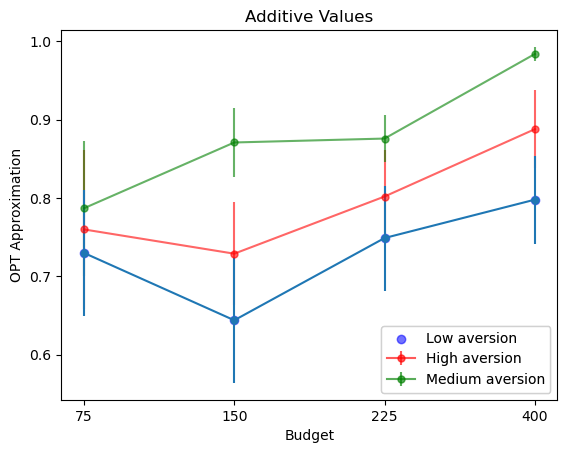

In [ ]:
fig, ax = plt.subplots()
budgets = ['75', '150', '225', '400']

scatter = ax.scatter(budgets, mean_lo, c='blue', label='Low aversion', alpha=0.5)
# legend1 = plt.legend(scatter.legend_elements("sizes",color='blue')[0], [100,200,500,1000, 2000], title="Number of Epochs",loc='lower right')
plt.errorbar(budgets, mean_hi, yerr=stdev_hi, c='red', label='High aversion',marker='o',markersize=5, alpha=0.6)
plt.errorbar(budgets, mean_mid, yerr=stdev_mid, c='green', markersize=5, marker='o', label='Medium aversion', alpha=0.6)
plt.errorbar(budgets, mean_lo, yerr=stdev_lo, markersize=5, marker='o')
legend2 = plt.legend(loc='lower right')
#ax.add_artist(legend1)
ax.add_artist(legend2)
plt.xlabel("Budget")
plt.ylabel("OPT Approximation")
plt.title('Additive Values')
plt.savefig('plots/additive.png')
plt.show()


In [ ]:
npga_groupby_risk = pd.pivot_table(npga, values = ['NPGA/OPT welf', 'NPGA/OPT welf - std'], index=['Value', 'Multiplier'], columns='Risk')
npga_groupby_risk
npga_groupby_risk.columns = ['_'.join(str(s).strip() for s in col if s) for col in npga_groupby_risk.columns]
npga_groupby_risk


final_results = pd.merge(low_all_risks, npga_groupby_risk, left_index=True, right_index=True)
final_results = final_results.iloc[:,[1,3,0,2,6,9,5,8,4,7]]
final_results = final_results.round(3)
lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacent']
final_results = final_results.loc[lst]

# final_results
for j in range(5):
    x = str(final_results.iloc[j, :].name[0]) + ' & '
    for i in range(10):
        if (i % 2 == 0): 
            x += str(final_results.iloc[j, :][i])
        else:
            x += ' (' + str(round(final_results.iloc[j, :][i],2)) +') & '
    print(x)

additive & 0.633 (0.09) & 1.0 (0.0) & 0.798 (0.06) & 0.984 (0.01) & 0.888 (0.05) & 
submodular & 0.736 (0.2) & 1.0 (0.0) & 0.886 (0.08) & 0.975 (0.03) & 0.999 (0.0) & 
superadditive & 0.628 (0.1) & 1.0 (0.0) & 0.927 (0.05) & 0.933 (0.04) & 0.957 (0.05) & 
corridors & 0.202 (0.14) & 1.0 (0.0) & 0.755 (0.1) & 0.828 (0.11) & 0.86 (0.1) & 
adjacent & 0.626 (0.09) & 1.0 (0.0) & 0.792 (0.07) & 0.835 (0.03) & 0.94 (0.02) & 


In [ ]:
# Payment computation

low_budget = data[data['Budget'].isin(conf[0])]
low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT pay', 'VCG/OPT pay', 'BFA/OPT pay', 'NPGA/OPT pay - std', 'VCG/OPT pay - std', 'BFA/OPT pay - std'].mean()
low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT pay', 'BFA/OPT pay','VCG/OPT pay - std', 'BFA/OPT pay - std'].mean()
npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT pay','NPGA/OPT pay - std'].mean()
low_all_risks


C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2569336500.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low = low_budget.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT pay', 'VCG/OPT pay', 'BFA/OPT pay', 'NPGA/OPT pay - std', 'VCG/OPT pay - std', 'BFA/OPT pay - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2569336500.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  low_all_risks = low.groupby(['Value', 'Multiplier'], sort=False)['VCG/OPT pay', 'BFA/OPT pay','VCG/OPT pay - std', 'BFA/OPT pay - std'].mean()
C:\Users\batziou\AppData\Local\Temp\ipykernel_12312\2569336500.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  npga = low.groupby(['Value', 'Multiplier', 'Risk'], sort=False)['NPGA/OPT pay','NP

,,VCG/OPT pay,BFA/OPT pay,VCG/OPT pay - std,BFA/OPT pay - std
Value,Multiplier,,,,
superadditive,2,12.073007,0.695969,1.520610,0.226253
additive,1,5.957463,0.853505,0.782745,0.119915
submodular,1,1.666747,0.814990,0.367696,0.156156
corridors,2,26.056008,0.875546,4.055125,0.133157
adjacent,1,5.916052,0.867968,0.729843,0.120267


In [ ]:
npga_groupby_risk = pd.pivot_table(npga, values = ['NPGA/OPT pay', 'NPGA/OPT pay - std'], index=['Value', 'Multiplier'], columns='Risk')
npga_groupby_risk
npga_groupby_risk.columns = ['_'.join(str(s).strip() for s in col if s) for col in npga_groupby_risk.columns]
npga_groupby_risk


final_results = pd.merge(low_all_risks, npga_groupby_risk, left_index=True, right_index=True)
final_results = final_results.iloc[:,[1,3,0,2,6,9,5,8,4,7]]
final_results = final_results.round(3)
lst = ['additive', 'submodular', 'superadditive', 'corridors', 'adjacent']
final_results = final_results.loc[lst]

final_results
# for j in range(5):
#     x = str(final_results.iloc[j, :].name[0]) + ' & '
#     for i in range(10):
#         if (i % 2 == 0): 
#             x += str(final_results.iloc[j, :][i])
#         else:
#             x += ' (' + str(round(final_results.iloc[j, :][i],2)) +') & '
#     print(x)

,,BFA/OPT pay,BFA/OPT pay - std,VCG/OPT pay,VCG/OPT pay - std,NPGA/OPT pay_1.0,NPGA/OPT pay - std_1.0,NPGA/OPT pay_0.75,NPGA/OPT pay - std_0.75,NPGA/OPT pay_0.5,NPGA/OPT pay - std_0.5
Value,Multiplier,,,,,,,,,,
additive,1,0.854,0.120,5.957,0.783,0.931,0.054,0.919,0.070,0.867,0.101
submodular,1,0.815,0.156,1.667,0.368,0.880,0.093,0.869,0.077,0.903,0.072
superadditive,2,0.696,0.226,12.073,1.521,0.941,0.042,0.943,0.041,0.941,0.044
corridors,2,0.876,0.133,26.056,4.055,0.893,0.081,0.886,0.099,0.889,0.096
adjacent,1,0.868,0.120,5.916,0.730,0.916,0.062,0.909,0.063,0.905,0.062


In [ ]:
# P-value statistical test

data = pd.read_csv("corridors-3.csv", delimiter= ',')

# If superadditive, select appropriate multiplier
data = data[data['multiplier'] == 2]

groupped = ['bfa_vcg_obj', 'bfa_budget_obj', 'vcg_budget_pay', 'bfa_budget_pay']
t_vals, p_vals = np.zeros(4), np.zeros(4)

data['bfa_vcg_obj'] = data['clock_mono_obj'] / data['vcg_obj'] 
data['bfa_budget_obj'] = data['clock_mono_obj'] / data['budget_obj'] 
data['vcg_budget_pay'] = data['vcg_pay'] / data['budget'] 
data['bfa_budget_pay'] =  data['bfa_pay'] / data['budget']
# # Generate columns for relative objective and payments
print('Testing Hypothesis - Mean of Two Distributions')

t_vals[0], p_vals[0] = stats.ttest_ind(data['clock_mono_obj'], data['vcg_obj'], equal_var=False)
t_vals[1], p_vals[1] = stats.ttest_ind(data['clock_mono_obj'], data['budget_obj'], equal_var=False)
t_vals[2], p_vals[2] =  stats.ttest_ind(data['vcg_pay'], data['budget'], equal_var=False)
t_vals[3], p_vals[3] = stats.ttest_ind(data['bfa_pay'], data['budget'], equal_var=False)

for i in range(4):
    print(f'({round(t_vals[i],3)}, {p_vals[i]:.2e})')

print('Testing Hypothesis - Distance of Relative Results from Mean')

for item in groupped:
    # print(data[item].mean())
    t_stat, p_value = stats.ttest_1samp(data[item], popmean=round(data[item].mean(),3), alternative='two-sided')
    print(f'({round(t_stat,3)}, {round(p_value,3)})')



FileNotFoundError: [Errno 2] No such file or directory: 'corridors-3.csv'